# Cross Validation

In this notebook, I validate choices using cross validation.

In [1]:
%matplotlib inline

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import pymc3 as pm
import theano.tensor as tt
import exoplanet as xo

import aviary as av

from tqdm import trange
import pickle

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Variables to be optimized:

In [13]:
young_limit = .7
hot_limit = 1.
dp, dc = .05, .05
cluster_old_err = .05  # The relative prot uncertainty on Ruprecht 147 and NGC6819
kinerr = .05  # The relative prot uncertainty on kinematic grid periods.
sun_err = .01  # The absolute prot uncertainty on the Sun's rotation period.

Load the kinematic data.

In [6]:
k = pd.read_csv("../data/mcquillan_kinematic_ages.csv")
k_lucy = pd.read_csv("../data/Gyrokinage2020_Prot.csv")
kl = pd.DataFrame(dict({"kepid": k_lucy.kepid.values,
                        "kin_age_lucy": k_lucy.kin_age.values,
                        "kin_age_err": k_lucy.kin_age_err.values}))
k = pd.merge(k, kl, on="kepid", how="left")

# Remove subgiants and photometric binaries
kin = k.iloc[k.flag.values == 1]
finite = np.isfinite(kin.Prot.values) & np.isfinite(kin.bprp_dered.values) & np.isfinite(kin.kin_age_lucy.values)
kin = kin.iloc[finite]

# Remove stars bluer than 1.5 and with kinematic ages greater than 6 as these are likely to be subgiants.
subs = (kin.bprp_dered.values < 1.5) & (kin.kinematic_age.values > 6)
kin = kin.iloc[~subs]

In [7]:
# Remove stars that fall beneath the lower envelope using the Angus + (2019) gyro relation.
no_young = kin.age.values > young_limit
kin = kin.iloc[no_young]

# Remove hot stars as the clusters provide better coverage.
cool = kin.bprp_dered.values > hot_limit
akin = kin.iloc[cool]
# akin = kin
# akin = akin.iloc[::5]

Create a grid over kinematic data.

In [10]:
logp = np.log10(akin.Prot.values)
pgrid = np.arange(min(logp), max(logp), dp)
cgrid = np.arange(min(akin.bprp_dered.values), max(akin.bprp_dered.values), dc)
P, C = np.meshgrid(pgrid, cgrid)
A = np.zeros_like(P)
prot_errs, npoints = [np.zeros_like(P) for i in range(2)]
for i in range(np.shape(A)[0]):
    for j in range(np.shape(A)[1]):
        b = (logp - .5*dp < P[i, j]) & (P[i, j] < logp + .5*dp)
        b &= (akin.bprp_dered.values - .5*dc < C[i, j]) & (C[i, j] < akin.bprp_dered.values + .5*dc)
        A[i, j] = np.median(akin.kin_age_lucy.values[b])
        prot_errs[i, j] = np.sqrt(sum((akin.Prot_err.values[b]/akin.Prot.values[b])**2)) \
            / np.sqrt(float(len(akin.kin_age_lucy.values[b])))
        npoints[i, j] = len(akin.kin_age_lucy.values[b])

finite = np.isfinite(C) & np.isfinite(P) & np.isfinite(A) & np.isfinite(prot_errs)
morethan = npoints[finite] > 1
C, P, A, prot_errs = C[finite][morethan], P[finite][morethan], A[finite][morethan], prot_errs[finite][morethan]

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Load cluster data from Get_cluster_scatter and add the Sun.

In [11]:
cluster_uncert = pd.read_csv("../data/clusters_with_uncertainties.csv")
cluster_x = np.concatenate((cluster_uncert.bprp.values, np.array([0.82])))
cluster_prot = np.concatenate((cluster_uncert.prot.values, np.array([26])))
cluster_age = np.concatenate((cluster_uncert.age.values, np.array([4.56])))
cluster_prot_errs = np.concatenate((cluster_uncert.prot_err.values, np.array([sun_err])))

In [14]:
# Decrease the uncertainties on the oldest clusters to cluster_old_err
select_old = cluster_age > 2.
cluster_prot_errs[select_old] = np.ones(len(cluster_prot_errs[select_old])) * cluster_old_err

# Combine clusters with kinematic grid
x = np.concatenate((cluster_x, np.ndarray.flatten(C)))
prot_err = np.concatenate((cluster_prot_errs, np.ndarray.flatten(10**P)*kinerr))
prot = np.concatenate((cluster_prot, np.ndarray.flatten(10**P)))
age = np.concatenate((cluster_age, np.ndarray.flatten(A)))

<ErrorbarContainer object of 3 artists>

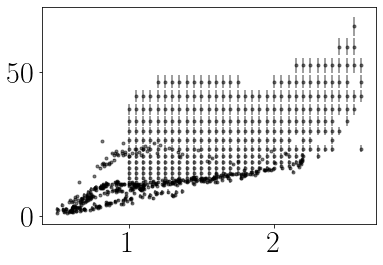

In [15]:
plt.errorbar(x, prot, yerr=prot_err, fmt="k.", alpha=.5)

Format data for GP fit.

In [17]:
# # Format for GP fit.
# inds = np.argsort(x)
# x1 = np.array(x[inds])
# x2 = np.log(np.array(age[inds]))
# y = np.log(np.array(prot[inds]))
# y_err = prot_err[inds]/prot[inds]

# mu1 = np.mean(x1)
# sd1 = np.std(x1)
# mu2 = np.mean(x2)
# sd2 = np.std(x2)

# x2_min = np.min(x2)

# xp1 = np.linspace(x1.min() - .2, x1.max() + .2, 1000)
# xp2 = np.linspace(x2.min(), x2.max(), 1000)
# xg1 = np.linspace(x1.min(), x1.max(), 5)
# xg2 = np.linspace(x2.min(), x2.max(), 10)
# xg2 = np.array([np.log(.12), np.log(.67), np.log(1), np.log(1.6), np.log(2.7), np.log(4.56), np.log(5), np.log(8), np.log(10)])
# print(np.unique(cluster_age))

[0.12 0.67 1.   2.5  2.7  4.56]


In [18]:
# with pm.Model() as model:
#     # x1 is color, x2 is age, y is period
    
#     # Parameters to infer.
#     teff_break = pm.Normal("teff_break", mu=0.9, sigma=.3)                     # the break in temperature (actually color)
#     log_period_break_m = pm.Normal("log_period_break_m", mu=0.0, sd=5)         # The weight of the x term
#     log_period_break_b = pm.Normal("log_period_break_b", mu=np.log(10), sd=5)  # The constant term
#     log_smooth = pm.Normal("log_smooth", mu=np.log(0.01), sigma=10.0)          # The smoothness of the break. (lower is smoother)
#     smooth = tt.exp(log_smooth)
#     slope_low = pm.Normal("slope_low", mu=0.0, sd=10.0)                        # The slope below the break
#     slope_high = pm.Normal("slope_high", mu=0.0, sd=10.0)                      # The slope above the break
#     log_s2 = pm.Normal("log_s2", mu=1.0, sd=10.0)                              # The log-variance of the rotation period data. 
    
#     def get_log_period_break(x2):
#         """
#         2nd-order polynomial describing relationship between period and age.
#         period = m*logage + b
#         """
#         return log_period_break_m * (x2 - x2_min) + log_period_break_b
    
#     # Mean model
#     def get_mean_model(x1, x2):
#         """
#         Predict the period at given values of color and age.
#         Use a smoothed broken power law for the period - color relation.
#         Use get_log_period_break for the period - age relation.
#         """
#         delta = x1 - teff_break
#         brk = get_log_period_break(x2)  # Get the period at this age
#         slope = slope_low / (1 + tt.exp(smooth * delta)) + slope_high / (1 + tt.exp(-smooth * delta))
#         return slope * delta + brk
    
#     mean_model = get_mean_model(x1, x2)
#     pm.Deterministic("mean_model", mean_model)
    
#     # GP parameters
#     log_amp = pm.Normal("log_amp", mu=np.log(np.var(y)), sigma=10.0)
#     log_ell = pm.Normal("log_ell1", mu=0.0, sigma=10., shape=2)
    
#     def get_K(x1, x2, xp1=None, xp2=None):
#         X = np.vstack(((x1 - mu1) / sd1, (x2 - mu2) / sd2))
        
#         if xp1 is None:
#             dX = (X[:, :, None] - X[:, None, :]) * tt.exp(-log_ell)[:, None, None]
#             r2 = tt.sum(dX ** 2, axis=0)
#         else:
#             Xp = tt.stack(((xp1 - mu1) / sd1, (xp2 - mu2) / sd2))
#             dX = (Xp[:, :, None] - X[:, None, :]) * tt.exp(-log_ell)[:, None, None]
#             r2 = tt.sum(dX ** 2, axis=0)
            
#         K = tt.exp(log_amp - 0.5 * r2)
#         return K
    
#     K = get_K(x1, x2)
#     K = tt.inc_subtensor(K[np.diag_indices(len(y))], tt.exp(log_s2) + y_err)
    
#     alpha = tt.slinalg.solve(K, y - mean_model)
#     pm.Deterministic("alpha", alpha)
#     for i, x2_ref in enumerate(xg2):
#         pred_model = get_mean_model(xp1, x2_ref)
#         Kp = get_K(x1, x2, xp1, x2_ref + np.zeros_like(xp1))
#         pred = tt.dot(Kp, alpha) + pred_model
#         pm.Deterministic("pred_{0}".format(i), pred)
    
#     # Likelihood
#     pm.MvNormal("obs", mu=mean_model, cov=K, observed=y)
        
#     x1_test = pm.Flat("x1_test", shape=(5000,))
#     x2_test = pm.Flat("x2_test", shape=(5000,))
#     K_test = get_K(x1, x2, x1_test, x2_test)
#     y_test = pm.Deterministic("y_test", tt.dot(K_test, alpha) + get_mean_model(x1_test, x2_test))
        
#     model.x1 = x1
#     model.x2 = x2
#     model.x2_min = x2_min
#     model.mu1 = mu1
#     model.mu2 = mu2
#     model.sd1 = sd1
#     model.sd2 = sd2
        
#     map_soln = model.test_point
#     map_soln = xo.optimize(map_soln, [slope_low, slope_high])
#     map_soln = xo.optimize(map_soln, [log_smooth])
#     map_soln = xo.optimize(map_soln, [teff_break, log_period_break_m, log_period_break_b])
#     map_soln = xo.optimize(map_soln, [slope_low, slope_high, log_smooth])
#     map_soln = xo.optimize(map_soln, [log_s2, log_amp, log_ell])
#     map_soln = xo.optimize(map_soln, [log_ell, log_amp, log_s2, slope_high, slope_low, log_smooth, log_period_break_b,
#                                       log_period_break_m, teff_break])

# print("done")

optimizing logp for variables: [slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1129.415348719169 -> -1125.3591675001921
optimizing logp for variables: [log_smooth]


message: Optimization terminated successfully.
logp: -1125.3591675001921 -> -1124.7004444403915
optimizing logp for variables: [log_period_break_b, log_period_break_m, teff_break]


message: Optimization terminated successfully.
logp: -1124.7004444403915 -> -1122.6986352753802
optimizing logp for variables: [log_smooth, slope_high, slope_low]


message: Optimization terminated successfully.
logp: -1122.6986352753802 -> -1120.8482727353658
optimizing logp for variables: [log_ell1, log_amp, log_s2]


message: Optimization terminated successfully.
logp: -1120.8482727353658 -> 203.56259748650805
optimizing logp for variables: [teff_break, log_period_break_m, log_period_break_b, log_smooth, slope_low, slope_high, log_s2, log_amp, log_ell1]



done


message: Optimization terminated successfully.
logp: 203.56259748650805 -> 216.50189377008883


In [19]:
# with open("../data/CV_gp_model.pkl", "wb") as f:
#     pickle.dump([model, map_soln], f)

In [29]:
filename = "../data/CV_gp_model.pkl"
av.fit_gp(x, age, prot, prot_err, filename)

TypeError: 'int' object is not subscriptable

(4, 5)

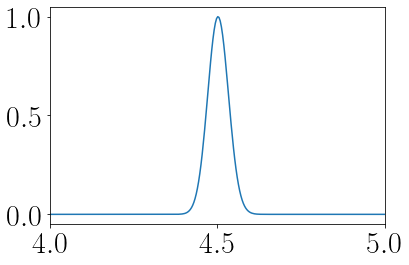

In [27]:
c = .82
prot = 26
prot_err = .1

class AgePosterior(object):

    def __init__(self, filename):
    
#     def load_model(filename):
    
        # Load the saved GP gyro model
        with open(filename, "rb") as f:
            model, map_soln = pickle.load(f)

        # Pull out the model and parameters
        with model:
            func = xo.get_theano_function_for_var(model.y_test)
            args = xo.utils.get_args_for_theano_function(map_soln)
            ind1 = model.vars.index(model.x1_test)
            ind2 = model.vars.index(model.x2_test)
        
        self.func, self.args, self.ind1, self.ind2 = func, args, ind1, ind2

    def get_post(self, c, prot, prot_err):
        """

        Args:
            c (float): color
            prot (float): prot (days)
            prot_err (float): absolute prot uncertainty (days)
        """

        self.args[self.ind2] = np.linspace(-1, 3, 5000)
        self.args[self.ind1] = c + np.zeros_like(args[ind2])

        posterior = np.exp(-0.5 * (self.func(*self.args) - np.log(prot))**2 / (prot_err / prot) ** 2)
        return np.exp(self.args[self.ind2]), posterior

ap = AgePosterior(filename)
color_array, posterior = ap.get_post(c, prot, prot_err)
plt.plot(color_array, posterior)
plt.xlim(4, 5)